## CMPS 261 - Mental Health Text Classification
### Data Exploration and Preprocessing

Import all the libraries required for data loading, preprocessing, model training, evaluating and saving.

In [3]:
# import all libraries
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib
import os

Load the sentiment analysis dataset and get a quick overview of its structure and size. As well as printing the first few rows.

In [5]:
# loading the dataset
df = pd.read_csv('Sentiment_analysis_dataset.csv')

# display first 5 rows
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 samples:")
print(df.head())

Dataset shape: (37130, 2)

First 5 samples:
                                           Statement      Status
0  life doesn’t feel worth it that’s kind of it? ...  Depression
1  This life sucks and if it were for my religiou...  Depression
2  its been 9 months now for our marriage and she...      Stress
3  I do not feel particularly sad or anxious or a...  Depression
4  I am taking Venlafaxine. it is an SSRI. does n...  Depression


Clean the data set by removing incomplete samples where the main text (labeled Statement) is missing. It's crucual since the model can't train on empty inputs.

In [7]:
# remove rows with missing statements
df.dropna(subset=['Statement'], inplace=True)

# data quality checks
print("Missing statements:", df['Statement'].isnull().sum())

Missing statements: 0


Encoding each text label into a numerical value.

In [9]:
# encode target labels into numbers
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['Status'])

# print label mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}


Creates a bar chart to help visualize how many statements belong to each category. Used for checking class imbalance which can affect model performance.

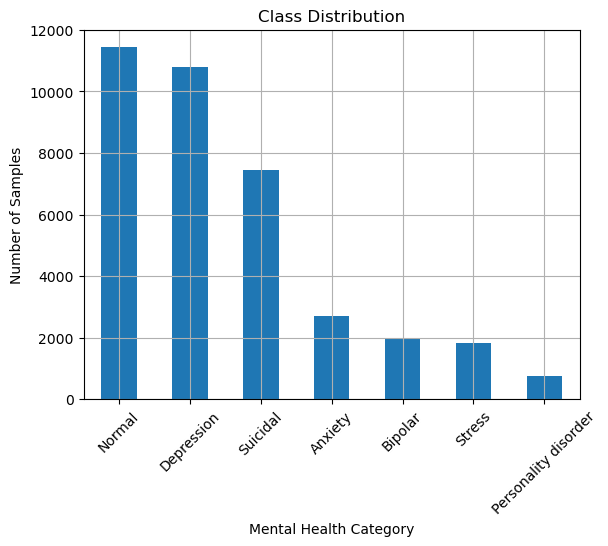

In [11]:
# check for imbalance in our data
# show value counts for each category
df['Status'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel("Mental Health Category")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Splits the dataset into 80% for training (to build the model) and 20% for testing (for evaluation). It uses stratified sampling to ensure a fair and balanced evaluation.

In [13]:
# input features and target labels
X = df['Statement']
y = df['label_encoded']

# split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=df['label_encoded'], random_state=42
)

# print split sizes
print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 29500
Test size: 7376


Transforms raw text data into numerical form using TF-IDF, which captures how important a word is in a document relative to the entire set.

In [15]:
# TF-IDF, convert the training text data into TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

Fixes class imbalance by generating synthetic samples for the underrepresented classes and helps the model learn equally from all classes. (improves generalization and prevents favoring)

In [17]:
# apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

### Logistic Regression Model Development

Trains a logistic regression model using the balanced training data. Sets max iterations to 1000 to ensure enough iterations to converge.

In [20]:
# train logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000)

Evaluates the performance of the trained logistic regression model on the test data. The classification report shows precision, recall and f1-score for each class.

In [22]:
# evaluate original test
y_pred = lr_model.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.753
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.78      0.72       538
           1       0.84      0.78      0.81       388
           2       0.76      0.63      0.69      2157
           3       0.91      0.89      0.90      2288
           4       0.57      0.71      0.63       151
           5       0.53      0.65      0.58       362
           6       0.63      0.73      0.68      1492

    accuracy                           0.75      7376
   macro avg       0.70      0.74      0.72      7376
weighted avg       0.76      0.75      0.75      7376



### XGBoost Model Development

Trains an XGBoost classifier with specified hyperparameters.

In [25]:
xgb_model = XGBClassifier(
    eval_metric='mlogloss',
    n_estimators=200,  
    max_depth=5,
)
xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

Fit the trained XHBoost model on TF-IDF transformed training data and predict labels for the TF-IDF transformed test set. Evaluates the model performance.

In [27]:
xgb_model.fit(X_train_tfidf, y_train)
y_pred = xgb_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.7777

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.83      0.77      0.80       538
             Bipolar       0.92      0.74      0.82       388
          Depression       0.70      0.73      0.71      2157
              Normal       0.89      0.96      0.92      2288
Personality disorder       0.85      0.55      0.67       151
              Stress       0.66      0.52      0.58       362
            Suicidal       0.68      0.67      0.68      1492

            accuracy                           0.78      7376
           macro avg       0.79      0.71      0.74      7376
        weighted avg       0.78      0.78      0.78      7376



### Final Model Training and Optimization

Save trained models and preprocessing components to disk, creates models and data directories if they dont exist.

In [30]:
# save both models and components
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)

joblib.dump(lr_model, 'models/logistic_regression.pkl')
joblib.dump(xgb_model, 'models/xgboost_model.pkl')
joblib.dump(vectorizer, 'models/tfidf_vectorizer.pkl')
joblib.dump(le, 'models/label_encoder.pkl')
joblib.dump(X_train_resampled, 'data/X_train_resampled.pkl')
joblib.dump(y_train_resampled, 'data/y_train_resampled.pkl')
joblib.dump(X_test_tfidf, 'data/X_test_tfidf.pkl')

['data/X_test_tfidf.pkl']

Loads the preprocessed training and test data that were saved previously.

In [32]:
# load preprocessed data
X_train_resampled = joblib.load('data/X_train_resampled.pkl')
y_train_resampled = joblib.load('data/y_train_resampled.pkl')
X_test_tfidf = joblib.load('data/X_test_tfidf.pkl')

It performs hyperparameter tuning for the XGBoost classifier using GridSearchCV to find the optimal parameters.

In [ ]:
# hyperparameter tuning
param_grid = {
    'n_estimators': [150, 200, 250],     
    'max_depth': [3, 5, 7]     
}

grid_search = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='mlogloss'),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1 
)
grid_search.fit(X_train_resampled, y_train_resampled)

Following hyperparameter tuning, the best model from the grid search results is chosen and its performance is evaluated on the test data.

In [ ]:
# best model
final_model = grid_search.best_estimator_

# evaluate final model
y_pred_final = final_model.predict(X_test_tfidf)
print(f"Final Model Accuracy: {accuracy_score(y_test, y_pred_final):.3f}")
print(f"Best Parameters: {grid_search.best_params_}")

Saves the final model and preprocessing objects for future use.

In [ ]:
joblib.dump(final_model, 'models/lr_model.pkl')
joblib.dump(vectorizer, 'models/tfidf_vectorizer.pkl')
joblib.dump(le, 'models/label_encoder.pkl')

### Result Analysis and Deployment

Loads the trained model and necessary preprocessing tools, along with the tes features.

In [ ]:
# load model/components/test data
model = joblib.load('models/logistic_regression_model.pkl')
vectorizer = joblib.load('models/tfidf_vectorizer.pkl')
le = joblib.load('models/label_encoder.pkl')

X_test = joblib.load('data/X_test.pkl')

Transforms the raw test data using the loaded TF-IDF vectorizer and generates predictions using the trained model.

In [ ]:
# predictions
X_test_tfidf = vectorizer.transform(X_test)
y_pred = model.predict(X_test_tfidf)

Prints a detailed classification report just like the one seen in the logistic regression and xgboost model evaluations.

In [ ]:
print("Final Classification Report:")
print(classification_report(
    y_test, 
    y_pred, 
    target_names=le.classes_
))

Takes text input and transforms it into TF-IDF features to predict the mental health status.

In [ ]:
# deployment example function
def predict_mental_health(text):
    """Predict mental health status from text input"""
    text_tfidf = vectorizer.transform([text])
    pred_num = model.predict(text_tfidf)[0]
    return le.inverse_transform([pred_num])[0]

Demonstrates how the predict_mental_health function works with sample text inputs.

In [ ]:
# example prediction
sample_text1 = "i feel extremely hopeless and empty inside"
sample_text2 = "i've been feeling extremely worried lately"
sample_text3 = "life has been amazing these days"
print("Example Predictions:")
print(f"Text 1: '{sample_text1}'")
print(f"Predicted: {predict_mental_health(sample_text1)}")
print(f"Text 2: '{sample_text2}'")
print(f"Predicted: {predict_mental_health(sample_text2)}")
print(f"Text 3: '{sample_text3}'")
print(f"Predicted: {predict_mental_health(sample_text3)}")